In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
import pickle
from copy import deepcopy
from collections import OrderedDict
import sys
import json

from pymongo import MongoClient

import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment import SentimentAnalyzer
from nltk.stem import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.externals import joblib

from textblob import TextBlob

import gensim
from gensim.models import *
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
from bqplot import pyplot as plt2

import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/bqplot/scales.py:433: DeprecationWarning: metadata {'args': (None,)} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  min = Date(default_value=None, allow_none=True).tag(sync=True)
/home/ubuntu/anaconda3/lib/pyt

In [3]:
mng_client = MongoClient()
mng_db = mng_client['news_db']
news_collection = mng_db.news_collection

In [5]:
#find all instances of NYT articles in the mongodb and add them to a list
nytimes = []
articles = news_collection.find({'publication':'New York Times'})
for document in articles:
    nytimes.append(document)

In [6]:
#create a dataframe from the list of nytimes articles
df_nyt = pd.DataFrame(nytimes)

In [ ]:
#show the head of the dataframe
df_nyt.head()

In [ ]:
#show the number of articles in the dataframe
len(df_nyt)

In [ ]:
#show the years for the articles
df_nyt['year'].value_counts()

In [7]:
#2015 and 2014 only have a total of 4 articles out of 7803. remove them.
df_nyt = df_nyt[df_nyt['year'] != 2015.0]
df_nyt = df_nyt[df_nyt['year'] != 2014.0]

In [ ]:
df_nyt['year'].value_counts()

In [ ]:
#remove all punctuation and non alpha/numeric characters from the content. before further cleaning and lemming of data
#df_nyt['no_punc'] = [re.sub("[^a-zA-Z0-9]+", ' ',s) for s in df_nyt['content']]

In [8]:
#create a function of stopwords for later removing stopwords from articles
def get_stopwords():    
    #Create a set of stop words to pull out of the dataset
    stop = stopwords.words('english')
    stop.append("new")
    stop.append("like")
    stop.append("u")
    stop.append("it")
    stop.append("s")
    stop.append("n")
    stop.append("t")
    stop.append('mr')
    stop.append('ms')
    stop.append('mrs')
    stop.append('Mr')
    stop.append('Ms')
    stop.append('Mrs')
    stop.append('said')
    stop.append('one')
    stop = set(stop)
    return (stop)

In [9]:
def clean_data(df):
    stop = get_stopwords()
    stemmer = SnowballStemmer('english')
    df['sentences'] = df.content.apply(sent_tokenize)
    df['sentences'] = [[re.sub("[^a-zA-Z0-9]+", ' ',s) for s in item] for item in df['sentences']]
    df['sent_length'] = df.apply(lambda row: len(row['sentences']),axis=1)
    df['no_punc'] = [re.sub("[^a-zA-Z0-9]+", ' ',s) for s in df_nyt['content']] 
    df['text_stem'] = df['no_punc'].apply(stemmer.stem)
    df['text_clean_stem'] = df['text_stem'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    df['words'] = df.text_clean_stem.apply(word_tokenize)
    df['word_pos'] = df.text_clean_stem.apply(word_tokenize).apply(pos_tag)
    return df

In [10]:
df_nyt = clean_data(df_nyt)

In [11]:
df_nyt.head()

_id                         author  \
0  5b0329e49959af5ca4022a43                     Carl Hulse   
1  5b0329e49959af5ca4022a44  Benjamin Mueller and Al Baker   
2  5b0329e49959af5ca4022a45                   Margalit Fox   
3  5b0329e49959af5ca4022a46               William McDonald   
4  5b0329e49959af5ca4022a47                  Choe Sang-Hun   

                                             content        date     id  \
0  WASHINGTON  —   Congressional Republicans have...  2016-12-31  17283   
1  After the bullet shells get counted, the blood...  2017-06-19  17284   
2  When Walt Disney’s “Bambi” opened in 1942, cri...  2017-01-06  17285   
3  Death may be the great equalizer, but it isn’t...  2017-04-10  17286   
4  SEOUL, South Korea  —   North Korea’s leader, ...  2017-01-02  17287   

   month     publication                                              title  \
0   12.0  New York Times  House Republicans Fret About Winning Their Hea...   
1    6.0  New York Times  Rift Between Officers and Residents as Killing...   
2    1.0  New York Times  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
3    4.0  New York Times  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
4    1.0  New York Times  Kim Jong-un Says North Korea Is Preparing to T...   

    url    year                                          sentences  \
0  None  2016.0  [WASHINGTON Congressional Republicans have a n...   
1  None  2017.0  [After the bullet shells get counted the blood...   
2  None  2017.0  [When Walt Disney s Bambi opened in 1942 criti...   
3  None  2017.0  [Death may be the great equalizer but it isn t...   
4  None  2017.0  [SEOUL South Korea North Korea s leader Kim sa...   

   sent_length                                            no_punc  \
0           26  WASHINGTON Congressional Republicans have a ne...   
1          215  After the bullet shells get counted the blood ...   
2          115  When Walt Disney s Bambi opened in 1942 critic...   
3           79  Death may be the great equalizer but it isn t ...   
4           25  SEOUL South Korea North Korea s leader Kim sai...   

                                           text_stem  \
0  washington congressional republicans have a ne...   
1  after the bullet shells get counted the blood ...   
2  when walt disney s bambi opened in 1942 critic...   
3  death may be the great equalizer but it isn t ...   
4  seoul south korea north korea s leader kim sai...   

                                     text_clean_stem  \
0  washington congressional republicans fear come...   
1  bullet shells get counted blood dries votive c...   
2  walt disney bambi opened 1942 critics praised ...   
3  death may great equalizer necessarily evenhand...   
4  seoul south korea north korea leader kim sunda...   

                                               words  \
0  [washington, congressional, republicans, fear,...   
1  [bullet, shells, get, counted, blood, dries, v...   
2  [walt, disney, bambi, opened, 1942, critics, p...   
3  [death, may, great, equalizer, necessarily, ev...   
4  [seoul, south, korea, north, korea, leader, ki...   

                                            word_pos  
0  [(washington, JJ), (congressional, JJ), (repub...  
1  [(bullet, NN), (shells, NNS), (get, VBP), (cou...  
2  [(walt, NN), (disney, NN), (bambi, NN), (opene...  
3  [(death, NN), (may, MD), (great, JJ), (equaliz...  
4  [(seoul, NN), (south, JJ), (korea, JJ), (north...

In [2]:
#save the dataframe as a pkl file for later recall
#df_nyt.to_pickle('nyt_df.pkl')
#read the dataframe from a pkl file
df_nyt = pd.read_pickle('nyt_df.pkl')

### Word2Vec

In [ ]:
#create a model using word2vec for the words in the df_nyt corpus.
model = gensim.models.Word2Vec(df_nyt['words'], size=100, window=5, min_count=10, workers=8, iter=10, sg=1)

In [ ]:
#save the word2vec model
#model.save('word2vec_model.model')
#load the word2vec model
#model = Word2Vec.load('word2vec_model.model')

In [ ]:
#use this to identify similar words
model.wv.most_similar('trump')

In [ ]:
#create a variable to use for a kmeans model, it is an array of vectors for each word in the model vocab
model_kmeans = model[model.wv.vocab]

In [ ]:
#example vector for the first word in the vocab
model_kmeans[0]

In [ ]:
#create a kmeans cluster using word vectors for words in the vocab based on the word-vec model
word_vec = model.wv.syn0
num_clusters = 80
kmeans_cluster = KMeans(num_clusters)
idx = kmeans_cluster.fit_predict(word_vec)

In [ ]:
word_cent = list(zip(model.wv.index2word, idx))

In [ ]:
#print out the words in each cluster
for cluster in range(num_clusters):
    print('\ncluster %d'%cluster)
    words=[]
    for i in range(0,len(word_cent)):
        if(word_cent[i][1] ==cluster):
            words.append(word_cent[i][0])
    print (words)

### End of Word2Vec

### Start LDA and KMeans Clustering

In [4]:
vectorizer = CountVectorizer(min_df=2, ngram_range=(1,3), max_df=.95, max_features = 50000)

In [5]:
nyt_vect = vectorizer.fit_transform(df_nyt['text_clean_stem'])

In [153]:
df_nyt['text_clean_stem'][0]

'washington congressional republicans fear comes health care lawsuit obama administration might win incoming trump administration could choose longer defend executive branch suit challenges administration authority spend billions dollars health insurance subsidies americans handing house republicans big victory issues sudden loss disputed subsidies could conceivably cause health care program implode leaving millions people without access health insurance republicans prepared replacement could lead chaos insurance market spur political backlash republicans gain full control government stave outcome republicans could find awkward position appropriating huge sums temporarily prop obama health care law angering conservative voters demanding end law years another twist donald j trump administration worried preserving executive branch prerogatives could choose fight republican allies house central questions dispute eager avoid ugly political pileup republicans capitol hill trump transition t

In [ ]:
#dump the vectorizer and nyt_vect into pkl files
#joblib.dump(vectorizer, 'vectorizer.pkl')
#joblib.dump(nyt_vect, 'nyt_vect.pkl')

In [ ]:
#vectorizer = joblib.load('vectorizer.pkl')
#nyt_vect = joblib.load('nyt_vect.pkl')

In [6]:
num_components = 60

In [7]:
lda = LatentDirichletAllocation(n_components=num_components, 
                                max_iter=7,
                                learning_method='online',
                                learning_offset=10.,
                                learning_decay=.7,
                                n_jobs=-1,
                                random_state=42)

In [8]:
lda.fit(nyt_vect)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=7, mean_change_tol=0.001,
             n_components=60, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [9]:
lda_topics = lda.transform(nyt_vect)

In [ ]:
#save the lda model to lda_nyt as a pkl file
#joblib.dump(lda, 'lda_nyt.pkl')
#load the model from the pickle file
#lda = joblib.load('lda_nyt.pkl')

In [19]:
vocab = vectorizer.get_feature_names()

In [20]:
for topic in range(num_components):
    print(f"TOPIC {topic}")
    for j in np.argsort(-lda.components_,1)[topic,:10]:
        print(vocab[j])
    print()

TOPIC 0
miami
dallas
brown
yards
bay
seattle
quarterback
pittsburgh
atlanta
cowboys

TOPIC 1
team
game
players
season
first
two
games
last
league
win

TOPIC 2
hastert
estonia
rusbridger
estonian
lupone
luik
tallinn
captain khan
dr bardack
dr oz

TOPIC 3
mexico
prison
brazil
de
drug
inmates
mexican
brazilian
gang
governor

TOPIC 4
flight
airport
travel
plane
passengers
air
airlines
airline
aircraft
travelers

TOPIC 5
moore
mary
tyler
sanders campaign
richards
quincea
dyke
yevtushenko
van dyke
quincea era

TOPIC 6
tebow
gurley
keillor
star trek
castillo
buffy
ayers
prairie home
mauna
bad moms

TOPIC 7
redstone
viacom
dauman
sudan
kosovo
davao
south sudan
squad
hacking team
herzer

TOPIC 8
wilmore
bitcoin
clinical trials
bello
biotech
innate
venezuelans
gottlieb
jason bourne
dr gottlieb

TOPIC 9
myanmar
san
aung
suu
kyi
suu kyi
aung san
san suu
san suu kyi
aung san suu

TOPIC 10
metropoulos
belldegrun
dr june
playboy mansion
cell therapy
redstone
therapeutics
amusements
immune cells
dr ro

In [21]:
lda.perplexity(nyt_vect)

7962.639599605149

### Explore pyLDAvis visualization for this dataset

In [ ]:
nyt_vect.shape

In [ ]:
#dump the vectorizer and nyt_vect into pkl files
#joblib.dump(lda_tf, 'lda_tf.pkl')
#load the model from the pickle file
#lda_tf = joblib.load('lda_tf.pkl')


In [25]:
pyLDAvis.sklearn.prepare(lda, nyt_vect, vectorizer)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.122338 -0.227015       1        1  17.402787
11     0.157324 -0.205885       2        1  14.563803
23     0.167758 -0.213918       3        1  11.448180
27     0.207493 -0.203164       4        1  10.101751
22     0.186212 -0.195784       5        1   7.506145
13     0.215241 -0.139732       6        1   6.738931
20     0.184938 -0.186216       7        1   5.484381
41     0.258343 -0.112543       8        1   5.204888
32     0.244170 -0.114383       9        1   4.416325
17     0.257858 -0.102335      10        1   2.873876
1      0.254240 -0.128122      11        1   2.642727
56     0.236126 -0.027472      12        1   1.923297
37     0.228404  0.060090      13        1   1.671416
42     0.238746  0.002855      14        1   1.073646
34     0.243504  0.026643      15        1   1.062091
35     0.213518  0.045936      16        1   0.736096
33     0.213852  0.048780      17        1   0.529426
43     0.147835  0.172359      18        1   0.478903
38     0.113884  0.145619      19        1   0.456350
12     0.146240  0.163659      20        1   0.436712
3      0.114409  0.162558      21        1   0.355122
54     0.110667  0.146352      22        1   0.322412
48     0.100203  0.147828      23        1   0.311507
39     0.136350  0.123714      24        1   0.302895
58     0.102345  0.150326      25        1   0.298611
4      0.084464  0.178402      26        1   0.259270
40     0.069785  0.163175      27        1   0.202811
57     0.038361  0.159244      28        1   0.179968
46     0.022369  0.150445      29        1   0.149141
0     -0.018130  0.135977      30        1   0.117991
15    -0.044557  0.114579      31        1   0.092945
47    -0.038548  0.128344      32        1   0.091747
29    -0.053085  0.110737      33        1   0.082995
53    -0.072195  0.100092      34        1   0.071371
49    -0.105312  0.071233      35        1   0.053913
51    -0.117361  0.056083      36        1   0.044991
50    -0.136558  0.036360      37        1   0.037833
7     -0.150203  0.017650      38        1   0.030336
9     -0.155326  0.012723      39        1   0.026212
5     -0.165705 -0.001484      40        1   0.023952
30    -0.171941 -0.010717      41        1   0.020466
25    -0.167784 -0.003848      42        1   0.019370
8     -0.183347 -0.032098      43        1   0.014774
55    -0.185109 -0.033711      44        1   0.014050
14    -0.182141 -0.028353      45        1   0.014049
19    -0.184751 -0.032826      46        1   0.012699
21    -0.185083 -0.034130      47        1   0.012221
2     -0.188234 -0.041536      48        1   0.010907
6     -0.189898 -0.046529      49        1   0.010043
59    -0.192226 -0.054795      50        1   0.008354
31    -0.192113 -0.055110      51        1   0.007708
52    -0.192921 -0.059105      52        1   0.007177
16    -0.193122 -0.060700      53        1   0.006652
28    -0.193166 -0.061208      54        1   0.006542
45    -0.193238 -0.061979      55        1   0.006412
24    -0.193382 -0.067053      56        1   0.005078
10    -0.193277 -0.069411      57        1   0.004468
44    -0.193130 -0.071380      58        1   0.004218
36    -0.193069 -0.071791      59        1   0.004169
26    -0.192061 -0.077430      60        1   0.002890, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
44984  Default  31537.000000          trump  31537.000000  30.0000  30.0000
44095  Default   6053.000000          times   6053.000000  29.0000  29.0000
48766  Default   5477.000000          women   5477.000000  28.0000  28.0000
39504  Default   4589.000000           show   4589.000000  27.0000  27.0000
46255  Default  10276.000000         united  10276.000000  26.0000  26.0000
9315   Default   6628.000000        company   6628.000000  25.0000  25.0000
3

### Trying to cluster documents into topics

In [10]:
dtm = nyt_vect.asfptype()

In [11]:
#use truncatedSVD to ... do stuff... rewrite this after I run the cell.
lsa = TruncatedSVD(100, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [12]:
var_explained = lsa.explained_variance_ratio_.sum()

In [13]:
km_clus = KMeans(n_clusters = 60, init='k-means++', max_iter=400, n_jobs=-1, verbose=0)

In [14]:
km_clus.fit(dtm_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=400,
    n_clusters=60, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [157]:
#save the lda model to lda_nyt as a pkl file
joblib.dump(km_clus, 'km_clus.pkl')
df_nyt.to_pickle('df_nyt.pkl')

In [15]:
import seaborn as sns

In [16]:
predicted_cluster = km_clus.predict(dtm_lsa)

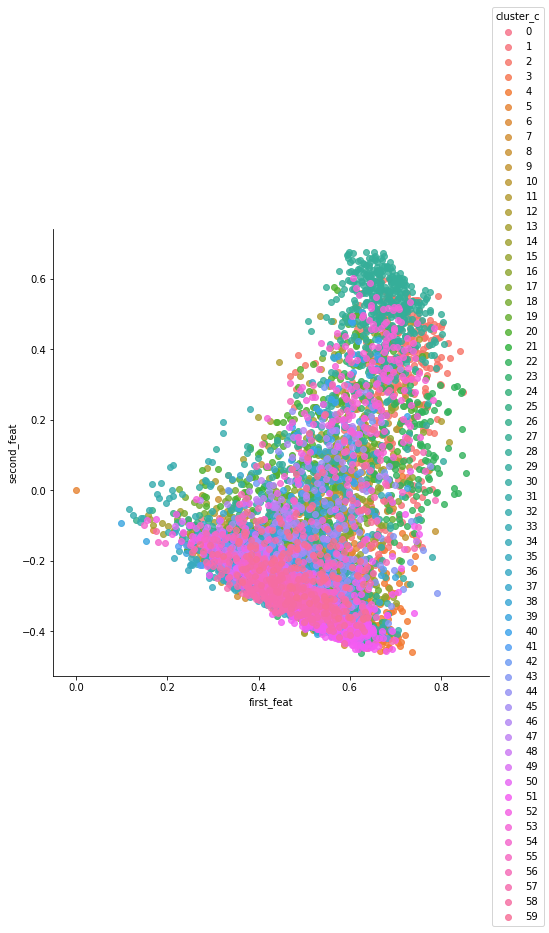

In [17]:
df = pd.DataFrame(dtm_lsa[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df, fit_reg = False, size = 7)

In [18]:
original_space_centroids = lsa.inverse_transform(km_clus.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [19]:
cluster_num = 60

In [20]:
terms = vectorizer.get_feature_names()

In [21]:
for i in range(cluster_num):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')  # print words in clusters
        print("")
    print(" ")
    print(" ")
print()

Cluster 0: 
 black
 white
 people
 also
 first
 time
 would
 women
 show
 years
 last
 many
 year
 made
 way
 even
 american
 two
 world
 life
 
 
Cluster 1: 
 times
 york
 trump
 president
 york times
 would
 news
 china
 also
 people
 first
 year
 last
 world
 american
 country
 day
 years
 government
 see
 
 
Cluster 2: 
 trump
 president
 would
 states
 united
 united states
 american
 obama
 also
 could
 administration
 people
 campaign
 first
 house
 country
 even
 many
 white
 government
 
 
Cluster 3: 
 women
 officials
 zika
 health
 dr
 also
 states
 people
 two
 florida
 virus
 cases
 united
 united states
 first
 children
 miami
 may
 even
 would
 
 
Cluster 4: 
 would
 people
 time
 could
 even
 think
 first
 way
 also
 years
 know
 get
 going
 show
 back
 much
 work
 make
 life
 two
 
 
Cluster 5: 
 government
 would
 officials
 also
 federal
 people
 security
 could
 states
 united
 department
 years
 administration
 law
 last
 two
 year
 united states
 many
 agency
 
 


In [138]:
df_nyt['label'].value_counts()

28    399
4     298
2     264
51    246
23    220
10    212
43    204
19    204
16    198
9     196
20    191
31    188
14    178
53    178
54    173
15    167
39    166
35    157
55    153
5     151
57    148
30    147
41    131
33    128
22    127
7     127
29    125
26    123
37    123
1     121
40    118
18    108
8     108
50    108
34    106
59    105
12    104
48    102
45    100
36    100
27     95
17     94
24     94
58     94
56     93
46     87
0      77
44     73
6      72
42     68
21     60
47     59
13     53
11     53
38     52
49     41
25     37
3      36
32     34
52     25
Name: label, dtype: int64

In [150]:
#df_nyt[df_nyt['label']==13]

In [22]:
label = km_clus.labels_

In [27]:
df_nyt['datetime'] = pd.to_datetime(df_nyt['date'])

In [23]:
df_nyt['label'] = label

In [28]:
df_nyt['counts'] = df_nyt.groupby(['label','datetime'])['datetime'].transform('count')

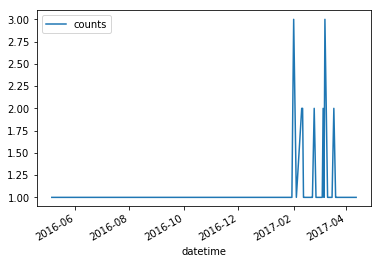

In [149]:
df_nyt[df_nyt['label'] ==13].plot(x='datetime', y='counts')

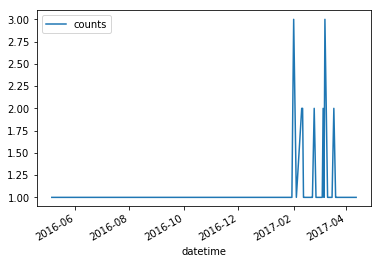

In [32]:
df_nyt[df_nyt['label'] ==13].plot(x='datetime', y='counts')

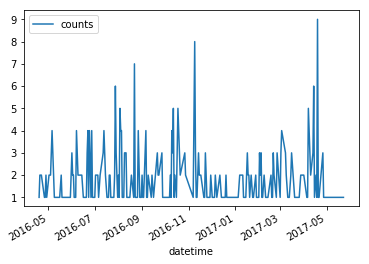

In [130]:
df_nyt[df_nyt['label'] ==28].plot(x='datetime', y='counts')

### Exploring plotly and cufflinks

In [40]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [86]:
df_nyt[df_nyt['label']==0]

_id  \
85    5b0329e49959af5ca4022a98   
144   5b0329e49959af5ca4022ad3   
151   5b0329e49959af5ca4022ada   
165   5b0329e49959af5ca4022ae8   
166   5b0329e49959af5ca4022ae9   
308   5b0329e49959af5ca4022b77   
376   5b0329e49959af5ca4022bbb   
409   5b0329e49959af5ca4022bdc   
484   5b0329e49959af5ca4022c27   
496   5b0329e49959af5ca4022c33   
712   5b0329e49959af5ca4022d0b   
826   5b0329e49959af5ca4022d7d   
832   5b0329e49959af5ca4022d83   
877   5b0329e49959af5ca4022db0   
904   5b0329e49959af5ca4022dcb   
932   5b0329e49959af5ca4022de7   
1096  5b0329e49959af5ca4022e8b   
1101  5b0329e49959af5ca4022e90   
1272  5b0329e49959af5ca4022f3b   
1366  5b0329e49959af5ca4022f99   
1475  5b0329e49959af5ca4023006   
1676  5b0329e49959af5ca40230cf   
1732  5b0329e49959af5ca4023107   
1947  5b0329e49959af5ca40231de   
2091  5b0329e49959af5ca402326e   
2101  5b0329e49959af5ca4023278   
2184  5b0329e49959af5ca40232cb   
2251  5b0329e59959af5ca402330e   
2445  5b0329e59959af5ca40233d0   
2456  5b0329e59959af5ca40233db   
...                        ...   
4984  5b0329e59959af5ca4023dbb   
5018  5b0329e59959af5ca4023ddd   
5261  5b0329e69959af5ca4023ed0   
5352  5b0329e69959af5ca4023f2b   
5415  5b0329e69959af5ca4023f6a   
5428  5b0329e69959af5ca4023f77   
5458  5b0329e69959af5ca4023f95   
5624  5b0329e69959af5ca402403b   
5858  5b0329e69959af5ca4024125   
5962  5b0329e69959af5ca402418d   
5997  5b0329e69959af5ca40241b0   
6096  5b0329e69959af5ca4024213   
6339  5b0329e69959af5ca4024306   
6372  5b0329e69959af5ca4024327   
6664  5b0329e69959af5ca402444b   
6829  5b0329e69959af5ca40244f0   
6854  5b0329e69959af5ca4024509   
6873  5b0329e69959af5ca402451c   
6885  5b0329e69959af5ca4024528   
6939  5b0329e69959af5ca402455e   
7003  5b0329e69959af5ca402459e   
7028  5b0329e69959af5ca40245b7   
7046  5b0329e69959af5ca40245c9   
7189  5b0329e69959af5ca4024658   
7477  5b0329e69959af5ca4024778   
7549  5b0329e69959af5ca40247c0   
7622  5b0329e69959af5ca4024809   
7689  5b0329e69959af5ca402484c   
7691  5b0329e69959af5ca402484e   
7788  5b0329e69959af5ca40248af   

                                                 author  \
85                                        Ana Marie Cox   
144                                         Bee Shapiro   
151                                   Salamishah Tillet   
165                                       Daniel Victor   
166                                    Vanessa Friedman   
308                                         Erin McCann   
376                                    Patrick Phillips   
409                                       Teresa Genaro   
484                                     Julie Turkewitz   
496                                        Alex Hawgood   
712                                        Jason Parham   
826                                         A. O. Scott   
832                                       Brooks Barnes   
877                 Rachel L. Swarns and Darcy Eveleigh   
904                                 Christopher D. Shea   
932                                 Jennifer Schuessler   
1096                                     Jon Caramanica   
1101                                   Vanessa Friedman   
1272                                        Tamara Best   
1366                                       Dave Itzkoff   
1475                                        Dana Thomas   
1676                                     Manohla Dargis   
1732                                       Matthew Haag   
1947                                      Randy Kennedy   
2091                                         Rick Rojas   
2101                                 Robert D. McFadden   
2184                                        Sam Roberts   
2251                                Michael M. Grynbaum   
2445                      A.O. Scott and Manohla Dargis   
2456                                    Elizabeth Paton   
...                                                 ...   
4984                          

In [101]:
df_plot = df_nyt[['label','datetime','counts']]

In [121]:
df_plot2 = df_plot.sort_values('datetime', axis=0)

In [127]:
df_plot[df_plot['label']==5]

label   datetime  counts
71        5 2017-01-22       1
113       5 2017-01-07       1
315       5 2017-01-13       1
380       5 2017-01-18       2
433       5 2017-01-19       3
436       5 2017-01-19       3
452       5 2017-01-20       1
566       5 2017-01-25       1
642       5 2017-01-31       2
681       5 2017-01-29       1
684       5 2017-02-24       4
766       5 2017-02-01       2
836       5 2017-02-04       2
924       5 2017-02-06       1
954       5 2017-02-07       1
967       5 2017-02-08       1
1004      5 2017-02-10       2
1010      5 2017-02-09       1
1058      5 2017-02-11       1
1157      5 2017-02-15       1
1174      5 2017-02-14       1
1234      5 2017-02-20       1
1274      5 2017-02-22       2
1302      5 2017-02-22       2
1313      5 2017-02-23       2
1325      5 2017-02-24       4
1348      5 2017-02-25       2
1359      5 2017-02-25       2
1421      5 2017-03-24       1
1534      5 2017-03-05       1
...     ...        ...     ...
6176      5 2016-11-20       1
6222      5 2017-04-26       1
6242      5 2016-11-21       1
6244      5 2017-04-06       1
6287      5 2017-04-19       1
6493      5 2017-04-13       3
6573      5 2016-05-23       1
6593      5 2016-06-06       1
6622      5 2016-12-21       3
6674      5 2016-07-06       1
6732      5 2017-01-18       2
6737      5 2016-09-02       2
6745      5 2016-08-05       1
6760      5 2017-02-03       1
6929      5 2016-10-06       1
6930      5 2016-10-04       1
6934      5 2016-11-05       2
6973      5 2016-10-18       1
6981      5 2016-10-27       1
7090      5 2016-12-11       1
7121      5 2016-12-14       1
7207      5 2016-10-17       1
7213      5 2016-05-25       1
7363      5 2016-09-14       1
7387      5 2017-03-02       1
7443      5 2016-11-15       2
7543      5 2016-07-28       1
7545      5 2016-11-05       2
7558      5 2016-06-24       3
7673      5 2016-12-08       1

[151 rows x 3 columns]

In [126]:
df_plot.sort_values('datetime', axis=0).iplot(x='datetime', y='counts')

In [134]:
df_nyt[df_nyt['label']==28]

_id  \
12    5b0329e49959af5ca4022a4f   
77    5b0329e49959af5ca4022a90   
114   5b0329e49959af5ca4022ab5   
115   5b0329e49959af5ca4022ab6   
164   5b0329e49959af5ca4022ae7   
242   5b0329e49959af5ca4022b35   
276   5b0329e49959af5ca4022b57   
295   5b0329e49959af5ca4022b6a   
301   5b0329e49959af5ca4022b70   
321   5b0329e49959af5ca4022b84   
323   5b0329e49959af5ca4022b86   
342   5b0329e49959af5ca4022b99   
360   5b0329e49959af5ca4022bab   
389   5b0329e49959af5ca4022bc8   
414   5b0329e49959af5ca4022be1   
445   5b0329e49959af5ca4022c00   
485   5b0329e49959af5ca4022c28   
487   5b0329e49959af5ca4022c2a   
529   5b0329e49959af5ca4022c54   
556   5b0329e49959af5ca4022c6f   
650   5b0329e49959af5ca4022ccd   
678   5b0329e49959af5ca4022ce9   
720   5b0329e49959af5ca4022d13   
774   5b0329e49959af5ca4022d49   
806   5b0329e49959af5ca4022d69   
825   5b0329e49959af5ca4022d7c   
872   5b0329e49959af5ca4022dab   
874   5b0329e49959af5ca4022dad   
948   5b0329e49959af5ca4022df7   
1070  5b0329e49959af5ca4022e71   
...                        ...   
7286  5b0329e69959af5ca40246b9   
7289  5b0329e69959af5ca40246bc   
7309  5b0329e69959af5ca40246d0   
7321  5b0329e69959af5ca40246dc   
7351  5b0329e69959af5ca40246fa   
7374  5b0329e69959af5ca4024711   
7394  5b0329e69959af5ca4024725   
7403  5b0329e69959af5ca402472e   
7416  5b0329e69959af5ca402473b   
7437  5b0329e69959af5ca4024750   
7438  5b0329e69959af5ca4024751   
7536  5b0329e69959af5ca40247b3   
7548  5b0329e69959af5ca40247bf   
7560  5b0329e69959af5ca40247cb   
7584  5b0329e69959af5ca40247e3   
7586  5b0329e69959af5ca40247e5   
7587  5b0329e69959af5ca40247e6   
7604  5b0329e69959af5ca40247f7   
7633  5b0329e69959af5ca4024814   
7669  5b0329e69959af5ca4024838   
7688  5b0329e69959af5ca402484b   
7727  5b0329e69959af5ca4024872   
7735  5b0329e69959af5ca402487a   
7744  5b0329e69959af5ca4024883   
7746  5b0329e69959af5ca4024885   
7748  5b0329e69959af5ca4024887   
7751  5b0329e69959af5ca402488a   
7753  5b0329e69959af5ca402488c   
7762  5b0329e69959af5ca4024895   
7785  5b0329e69959af5ca40248ac   

                                                 author  \
12                                      Maggie Haberman   
77                                        Chris Buckley   
114                                     Laura M. Holson   
115                     Eric Lipton and Maggie Haberman   
164                                       Patrick Healy   
242                                     Nicholas Fandos   
276                                        Trip Gabriel   
295                                    Vanessa Friedman   
301                                           Sopan Deb   
321                                        Mark Landler   
323                                     Michael Paulson   
342                                         Amanda Hess   
360                         Megan Twohey and Steve Eder   
389                                        Megan Twohey   
414                                     Maggie Haberman   
445                          Sopan Deb and Katie Rogers   
485                                          Rick Lyman   
487                                     Jonathan Martin   
529                                        Dave Itzkoff   
556                                    James Poniewozik   
650                                         Erin McCann   
678                                       David Barstow   
720                                       Farhad Manjoo   
774                       Barry Meier and Susanne Craig   
806                            Lawrence K. Altman, M.d.   
825                                      Mark Leibovich   
872                                       Rachel Abrams   
874                       Susanne Craig and Eric Lipton   
948                                  Richard Pérez-Peña   
1070                                          Sopan Deb   
...                                                 ...   
7286                          

In [132]:
df_plot[df_plot['label']==28].sort_values('datetime', axis=0).iplot(x='datetime',y='counts')

In [64]:
df_plot.iplot(x='datetime',y='counts')

In [46]:
df_plot.iplot(x='datetime', y='counts')

In [97]:
df_plot.head()

datetime  counts
85  2017-01-07       1
144 2017-01-25       2
151 2017-01-15       1
165 2017-01-09       1
166 2017-01-10       1

In [104]:
df_010 = df_nyt.loc[df_nyt['label'].isin([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59])][['label','datetime','counts']]


In [113]:
newdf = pd.get_dummies(df_010['label'])

In [106]:
newdf

0   1   2   3   4   5   6   7   8   9  ...  50  51  52  53  54  55  56  \
0      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
1      0   0   0   0   0   0   0   1   0   0 ...   0   0   0   0   0   0   0   
2      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
3      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
4      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
5      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
6      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
8      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
9      0   0   0   0   0   0   0   0   0   0 ...   0   1   0   0   0   0   0   
10     0   0   1   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
11     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
12     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
13     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
14     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
15     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
16     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   1   0   
17     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
18     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
19     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
20     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
21     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
22     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
23     0   0   0   0   1   0   0   0   0   0 ...   0   0   0   0   0   0   0   
24     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
25     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
26     0   1   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
27     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
28     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
29     0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  .. ...  ..  ..  ..  ..  ..  ..  ..   
7773   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7774   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7775   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7776   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   0   0   
7777   0   0   1   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7778   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7779   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7780   0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
7781   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7782   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7783   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7784   0   1   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7785   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7786   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7787   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7788   1   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7789   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7790   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   
7791  

In [114]:
newdf2 = df_plot.join(newdf)

In [109]:
label = newdf2['label']

In [118]:
newdf2[newdf2['label'] ==label]['counts']

0        1
1        2
2        2
3        1
4        1
5        2
6        1
7        2
8        1
9        1
10       1
11       1
12       1
13       1
14       3
15       1
16       1
17       1
18       2
19       1
20       1
21       2
22       1
23       1
24       1
25       1
26       1
27       1
28       2
29       4
        ..
7773     1
7774     3
7775     1
7776     5
7777     4
7778     1
7779     4
7780     2
7781     4
7782     1
7783     1
7784     1
7785     1
7786     2
7787     1
7788     1
7789     1
7790     1
7791     3
7792     1
7793     1
7794     4
7795     2
7796     3
7797    21
7798     1
7799     2
7800     3
7801     2
7802     1
Name: counts, Length: 7799, dtype: int64

In [115]:
newdf2

label   datetime  counts  0  1  2  3  4  5  6 ...  50  51  52  53  54  \
0        27 2016-12-31       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
1         7 2017-06-19       2  0  0  0  0  0  0  0 ...   0   0   0   0   0   
2        17 2017-01-06       2  0  0  0  0  0  0  0 ...   0   0   0   0   0   
3        14 2017-04-10       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
4        13 2017-01-02       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
5        14 2017-01-02       2  0  0  0  0  0  0  0 ...   0   0   0   0   0   
6        37 2017-01-02       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7        57 2017-02-08       2  0  0  0  0  0  0  0 ...   0   0   0   0   0   
8        14 2016-12-31       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
9        51 2016-12-31       1  0  0  0  0  0  0  0 ...   0   1   0   0   0   
10        2 2017-01-03       1  0  0  1  0  0  0  0 ...   0   0   0   0   0   
11       44 2017-01-05       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
12       28 2017-01-02       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
13       23 2017-01-02       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
14       23 2017-04-14       3  0  0  0  0  0  0  0 ...   0   0   0   0   0   
15       39 2017-01-02       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
16       55 2017-01-02       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
17       15 2017-01-02       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
18       36 2017-01-03       2  0  0  0  0  0  0  0 ...   0   0   0   0   0   
19       41 2017-01-03       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
20       10 2017-01-03       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
21       14 2017-01-02       2  0  0  0  0  0  0  0 ...   0   0   0   0   0   
22       36 2017-01-01       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
23        4 2017-01-01       1  0  0  0  0  1  0  0 ...   0   0   0   0   0   
24       29 2017-01-02       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
25       29 2017-01-03       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
26        1 2017-01-03       1  0  1  0  0  0  0  0 ...   0   0   0   0   0   
27       24 2017-01-05       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
28       36 2017-01-03       2  0  0  0  0  0  0  0 ...   0   0   0   0   0   
29       46 2017-01-17       4  0  0  0  0  0  0  0 ...   0   0   0   0   0   
...     ...        ...     ... .. .. .. .. .. .. .. ...  ..  ..  ..  ..  ..   
7773     26 2017-04-11       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7774     26 2017-04-13       3  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7775     23 2016-12-22       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7776     54 2017-04-11       5  0  0  0  0  0  0  0 ...   0   0   0   0   1   
7777      2 2017-04-14       4  0  0  1  0  0  0  0 ...   0   0   0   0   0   
7778     46 2017-04-17       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7779     30 2017-04-13       4  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7780      6 2016-10-19       2  0  0  0  0  0  0  1 ...   0   0   0   0   0   
7781     19 2016-04-26       4  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7782     46 2016-05-17       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7783     20 2016-11-02       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7784      1 2016-06-10       1  0  1  0  0  0  0  0 ...   0   0   0   0   0   
7785     28 2016-11-22       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7786     26 2016-06-15       2  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7787     19 2016-08-01       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7788      0 2016-12-21       1  1  0  0  0  0  0  0 ...   0   0   0   0   0   
7789     29 2016-06-30       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7790     30 2017-03-08       1  0  0  0  0  0  0  0 ...   0   0   0   0   0   
7791     20 2017-01-16       3  0  0  0  0  0  0  0 ... 

In [82]:
df_lab = pd.DataFrame(columns=['datetime',1,2,3,4,5,6,7,8,9,10])

In [83]:
df_lab

Empty DataFrame
Columns: [datetime, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Index: []